In [1]:
import sys
import os
from itertools import product
import math
import numpy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from scipy.cluster.hierarchy import dendrogram, leaves_list
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE, MDS
# import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

sys.path.append(os.path.abspath("../sim_metric/dists"))
from scoring import *

# Load distances and representations

In [2]:
pretrained = True
folder = "estimated_distances_increasing_n/untrained"
if pretrained:
    folder = "estimated_distances_increasing_n/pretrained"

In [3]:
stats = np.load(f"distances/train/pretrained/stats.npz")
model_names = stats["model_names"]

In [4]:
print(model_names)

['alexnet_pretrained_rep' 'convnext_base_pretrained_rep'
 'convnext_large_pretrained_rep' 'convnext_small_pretrained_rep'
 'convnext_tiny_pretrained_rep' 'densenet_pretrained_rep'
 'efficientnet_b0_pretrained_rep' 'efficientnet_b1_pretrained_rep'
 'efficientnet_b2_pretrained_rep' 'efficientnet_b3_pretrained_rep'
 'efficientnet_b4_pretrained_rep' 'efficientnet_b5_pretrained_rep'
 'efficientnet_b6_pretrained_rep' 'efficientnet_b7_pretrained_rep'
 'googlenet_pretrained_rep' 'inception_pretrained_rep'
 'mnasnet_pretrained_rep' 'mobilenet_v2_pretrained_rep'
 'mobilenet_v3_large_pretrained_rep' 'mobilenet_v3_small_pretrained_rep'
 'regnet_x_16gf_pretrained_rep' 'regnet_x_1_6gf_pretrained_rep'
 'regnet_x_32gf_pretrained_rep' 'regnet_x_3_2gf_pretrained_rep'
 'regnet_x_400mf_pretrained_rep' 'regnet_x_800mf_pretrained_rep'
 'regnet_x_8gf_pretrained_rep' 'regnet_y_16gf_pretrained_rep'
 'regnet_y_1_6gf_pretrained_rep' 'regnet_y_32gf_pretrained_rep'
 'regnet_y_3_2gf_pretrained_rep' 'regnet_y_400mf_

In [5]:
# Load ImageNet representations
reps = {}
for model_name in model_names:
    print(model_name)
    rep1 = np.load("reps/train/10000_eval/" + model_name + ".npy")
    # center and normalize
    rep1 = rep1 - rep1.mean(axis=1, keepdims=True)
    rep1 = rep1 / np.linalg.norm(rep1)
    rep1 = rep1 * np.sqrt(rep1.shape[1])
    reps[model_name] = rep1

alexnet_pretrained_rep
convnext_base_pretrained_rep
convnext_large_pretrained_rep
convnext_small_pretrained_rep
convnext_tiny_pretrained_rep
densenet_pretrained_rep
efficientnet_b0_pretrained_rep
efficientnet_b1_pretrained_rep
efficientnet_b2_pretrained_rep
efficientnet_b3_pretrained_rep
efficientnet_b4_pretrained_rep
efficientnet_b5_pretrained_rep
efficientnet_b6_pretrained_rep
efficientnet_b7_pretrained_rep
googlenet_pretrained_rep
inception_pretrained_rep
mnasnet_pretrained_rep
mobilenet_v2_pretrained_rep
mobilenet_v3_large_pretrained_rep
mobilenet_v3_small_pretrained_rep
regnet_x_16gf_pretrained_rep
regnet_x_1_6gf_pretrained_rep
regnet_x_32gf_pretrained_rep
regnet_x_3_2gf_pretrained_rep
regnet_x_400mf_pretrained_rep
regnet_x_800mf_pretrained_rep
regnet_x_8gf_pretrained_rep
regnet_y_16gf_pretrained_rep
regnet_y_1_6gf_pretrained_rep
regnet_y_32gf_pretrained_rep
regnet_y_3_2gf_pretrained_rep
regnet_y_400mf_pretrained_rep
regnet_y_800mf_pretrained_rep
regnet_y_8gf_pretrained_rep
resnet

In [6]:
stats = np.load(f"{folder}/computed_distances.npz")
dist_pairs_saved = stats["dist_pairs_saved"]

FileNotFoundError: [Errno 2] No such file or directory: 'estimated_distances_increasing_n/pretrained/computed_distances.npz'

In [33]:
distances = {}
def symmetrize(A):
    n = A.shape[0]
    B = A.copy()
    B[np.tril_indices(n)] = B.T[np.tril_indices(n)]
    return B
for distname in distnames:
    print(distname)
    curr_dist = np.load(f"{folder}/{distname}.npy")  
    distances[distname] = symmetrize(curr_dist)
#     print(distances[distname])

NameError: name 'distnames' is not defined

In [34]:
def predictor_dist_temp(A, B, evals_a=None, evecs_a=None, evals_b=None, evecs_b=None, cov_ab=None, lmbda=0):
    """
    Computes distance bewteen best linear predictors on representations A and B
    """
    k, n = A.shape
    l, _ = B.shape
    assert k <= n
    assert l <= n
    
    if evals_a is None or evecs_a is None:
        evals_a, evecs_a = np.linalg.eigh(A @ A.T)
    if evals_b is None or evecs_b is None:
        evals_b, evecs_b = np.linalg.eigh(B @ B.T)

    evals_a = (evals_a + np.abs(evals_a)) / (2 * n)
    if lmbda > 0:
        inv_a_lmbda = np.array([1 / (x + lmbda) if x > 0 else 1 / lmbda for x in evals_a])
    else:
        inv_a_lmbda = np.array([1 / x if x > 0 else 0 for x in evals_a])

    evals_b = (evals_b + np.abs(evals_b)) / (2 * n)
    if lmbda > 0:
        inv_b_lmbda = np.array([1 / (x + lmbda) if x > 0 else 1 / lmbda for x in evals_b])
    else:
        inv_b_lmbda = np.array([1 / x if x > 0 else 0 for x in evals_b])
    
    
# #     w = lmbda / evals_a
#     evals_a_times_inv = np.array([1 / (1 + lmbda / x) if x < 10**2 * lmbda else 1 - lmbda / x + ((lmbda / x)**2) - ((lmbda / x)**3) for x in evals_a])
#     T1 = np.sum(np.square(evals_a_times_inv))
    
# #     w2 = lmbda / evals_b
#     evals_b_times_inv = np.array([1 / (1 + lmbda / x) if x < 10**2 * lmbda else 1 - lmbda / x + ((lmbda / x)**2) - ((lmbda / x)**3) for x in evals_b])
#     T2 = np.sum(np.square(evals_b_times_inv))
    
    T1 = np.sum(np.square(evals_a * inv_a_lmbda))
    T2 = np.sum(np.square(evals_b * inv_b_lmbda))
    
    if cov_ab is None:
        cov_ab = A @ B.T / n
    T3 = np.trace(
        (np.diag(np.sqrt(inv_a_lmbda)) @ evecs_a.T)
        @ cov_ab
        @ (evecs_b @ np.diag(inv_b_lmbda) @ evecs_b.T)
        @ cov_ab.T
        @ (evecs_a @ np.diag(np.sqrt(inv_a_lmbda)))
    )
    
#     T3 = 0
    
    return T1 + T2 - 2*T3

In [13]:

old_model_names = model_names

In [14]:
model_names = old_model_names

In [15]:
sub_index = np.where(np.asarray(range(len(model_names))) % 3 == 0)

In [16]:
print(sub_index)

(array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42]),)


In [17]:
print(type(model_names))

<class 'numpy.ndarray'>


In [18]:
model_names = np.asarray([old_model_names[i] for i in sub_index])[0,:]

In [19]:
print(model_names.shape)

(15,)


In [42]:
print(model_names)

['alexnet_pretrained_rep' 'convnext_small_pretrained_rep'
 'efficientnet_b0_pretrained_rep' 'efficientnet_b3_pretrained_rep'
 'efficientnet_b6_pretrained_rep' 'inception_pretrained_rep'
 'mobilenet_v3_large_pretrained_rep' 'regnet_x_1_6gf_pretrained_rep'
 'regnet_x_400mf_pretrained_rep' 'regnet_y_16gf_pretrained_rep'
 'regnet_y_3_2gf_pretrained_rep' 'regnet_y_8gf_pretrained_rep'
 'shufflenet_pretrained_rep' 'vit_b_16_pretrained_rep'
 'vit_l_32_pretrained_rep']


In [43]:
n_vals = np.arange(1400,5200,400)

In [44]:
print(n_vals)

[1400 1800 2200 2600 3000 3400 3800 4200 4600 5000]


In [47]:
np.arange(1200,10200,800)

array([ 1200,  2000,  2800,  3600,  4400,  5200,  6000,  6800,  7600,
        8400,  9200, 10000])

In [48]:
# Estimate eigenvalues
lambda_vals = [np.inf, 10,5,4,3,2,1,0,-1]
n_vals = np.arange(1200,10200,800)
d_mat = {}
evals_evecs = {}
for model_name in model_names:
    print(model_name)
    for n_ind in range(len(n_vals)):
        n = n_vals[n_ind]
        A = reps[model_name][:,0:n]
        evals_a, evecs_a = np.linalg.eigh(A @ A.T)
        evals_evecs[(model_name, n)] = (evals_a, evecs_a)
        
for ind_1 in range(len(model_names)):
    print(ind_1,'/',len(model_names))
    model_name1 = model_names[ind_1]
    for ind_2 in range(ind_1+1,len(model_names)):
        model_name2 = model_names[ind_2]
        print(model_name1, model_name2)
        new_mat = np.zeros((len(lambda_vals),len(n_vals)))
        
        for n_ind in range(len(n_vals)):
            n = n_vals[n_ind]
            A = reps[model_name1][:,0:n]
            B = reps[model_name2][:,0:n]
            evals_a, evecs_a = evals_evecs[(model_name1, n)]
            evals_b, evecs_b = evals_evecs[(model_name2, n)]
            covAB = A @ B.T / n
#             print(n)
            for i in range(len(lambda_vals)):
                if lambda_vals[i] == np.inf:
                    curr_dist = predictor_dist_temp(A, B, evals_a=evals_a, evecs_a = evecs_a, evals_b = evals_b, evecs_b = evecs_b, cov_ab = covAB, lmbda=0)
#                     print('0\t',curr_dist)
                    new_mat[i,n_ind] = curr_dist
                else:
                    curr_dist = predictor_dist_temp(A, B, evals_a=evals_a, evecs_a = evecs_a, evals_b = evals_b, evecs_b = evecs_b, cov_ab = covAB, lmbda=math.pow(10,-lambda_vals[i]))
#                     print('1e-' + str(lambda_vals[i]) + '\t',curr_dist)
                    new_mat[i,n_ind] = curr_dist
        
        d_mat[(model_name1, model_name2)] = new_mat
    

alexnet_pretrained_rep
convnext_small_pretrained_rep
efficientnet_b0_pretrained_rep
efficientnet_b3_pretrained_rep
efficientnet_b6_pretrained_rep
inception_pretrained_rep
mobilenet_v3_large_pretrained_rep
regnet_x_1_6gf_pretrained_rep
regnet_x_400mf_pretrained_rep
regnet_y_16gf_pretrained_rep
regnet_y_3_2gf_pretrained_rep
regnet_y_8gf_pretrained_rep
shufflenet_pretrained_rep
vit_b_16_pretrained_rep
vit_l_32_pretrained_rep
0 / 15
alexnet_pretrained_rep convnext_small_pretrained_rep
alexnet_pretrained_rep efficientnet_b0_pretrained_rep
alexnet_pretrained_rep efficientnet_b3_pretrained_rep
alexnet_pretrained_rep efficientnet_b6_pretrained_rep
alexnet_pretrained_rep inception_pretrained_rep
alexnet_pretrained_rep mobilenet_v3_large_pretrained_rep
alexnet_pretrained_rep regnet_x_1_6gf_pretrained_rep
alexnet_pretrained_rep regnet_x_400mf_pretrained_rep
alexnet_pretrained_rep regnet_y_16gf_pretrained_rep
alexnet_pretrained_rep regnet_y_3_2gf_pretrained_rep
alexnet_pretrained_rep regnet_y_8gf_

In [8]:
import pickle

In [9]:
# pickle.dump(d_mat, open("estimated_distances_increasing_n/trained/imagenet_dists_10000.pkl", "wb"))

In [10]:
d_mat = pickle.load(open("estimated_distances_increasing_n/trained/imagenet_dists_10000.pkl", "rb"))

In [11]:
lambda_vals = [np.inf, 10,5,4,3,2,1,0,-1]
n_vals = np.arange(1200,10200,800)

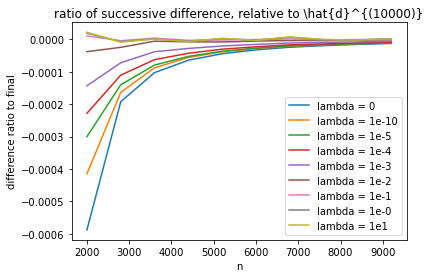

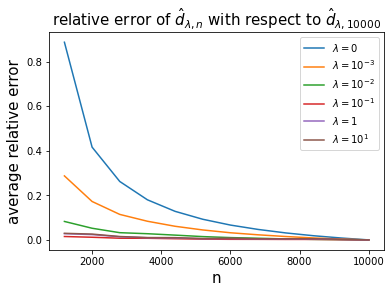

In [29]:
for i in range(len(lambda_vals)):
    if lambda_vals[i] == np.inf:
        currlabel = 'lambda = 0'
    elif lambda_vals[i] >= 0:
        currlabel ='lambda = 1e-' + str(lambda_vals[i])
    elif lambda_vals[i] < 0:
        currlabel ='lambda = 1e' + str(-lambda_vals[i])
    
    curr_l = np.zeros(len(n_vals))
    for ind_1 in range(len(model_names)):
        model_name1 = model_names[ind_1]
        for ind_2 in range(ind_1+1, len(model_names)):
            model_name2 = model_names[ind_2]
            
            curr_mat = d_mat[(model_name1, model_name2)]
            final_val = curr_mat[i,-1]
            curr_l = curr_l + curr_mat[i,:] / final_val
    avg_l = curr_l / (len(model_names) * (len(model_names) - 1) / 2)
    diff_l = (avg_l[0:-2] - avg_l[1:-1]) / (n_vals[1] - n_vals[0])
#     print(diff_l)
    plt.plot(n_vals[1:-1], diff_l, label=currlabel)
#     plt.ylim((0,2))
#     plt.ylim((-0.2,0.2))
plt.legend()
plt.title('ratio of successive difference, relative to \hat{d}^{(10000)}')
plt.xlabel('n')
plt.ylabel('difference ratio to final')
plt.show()

for i in range(len(lambda_vals)):
    if lambda_vals[i] == np.inf:
        currlabel = '$\lambda = 0$'
    elif lambda_vals[i] == 0:
        currlabel = '$\lambda = 1$'
    elif lambda_vals[i] >= 0:
        currlabel ='$\lambda = 10^{-' + str(lambda_vals[i]) + '}$'
    elif lambda_vals[i] < 0:
        currlabel ='$\lambda = 10^{' + str(-lambda_vals[i]) + '}$'
        
    if lambda_vals[i] == 10 or lambda_vals[i] == 5 or lambda_vals[i] == 4:
        continue
    
    curr_l = np.zeros(len(n_vals))
    curr_err = np.zeros(len(n_vals))
    for ind_1 in range(len(model_names)):
        model_name1 = model_names[ind_1]
        for ind_2 in range(ind_1+1, len(model_names)):
            model_name2 = model_names[ind_2]
            
            curr_mat = d_mat[(model_name1, model_name2)]
            final_val = curr_mat[i,-1]
            curr_l = curr_l + curr_mat[i,:] / final_val
            curr_err = curr_err + np.abs((curr_mat[i,:] - final_val) / final_val)
    avg_err = curr_err / (len(model_names) * (len(model_names) - 1) / 2)
    avg_l = curr_l / (len(model_names) * (len(model_names) - 1) / 2)
#     diff_l = avg_l[0:-2] - avg_l[1:-1]
#     print(diff_l)
#     plt.plot(n_vals, avg_l, label=currlabel)
    plt.plot(n_vals, avg_err, label=currlabel)
#     plt.ylim((0,2))
#     plt.ylim((-0.2,0.2))
plt.legend()
plt.title('relative error of $\hat{d}_{\lambda,n}$ with respect to $\hat{d}_{\lambda,10000}$', fontsize=15)
plt.xlabel('n', fontsize=15)
plt.ylabel('average relative error', fontsize=15)
plt.savefig('../paper_figures/convergence_relative_error.pdf')
plt.show()

In [39]:
old_model_names = model_names

In [69]:
model_names = old_model_names

In [70]:
print(model_names)

['alexnet_pretrained_rep' 'convnext_small_pretrained_rep'
 'efficientnet_b0_pretrained_rep' 'efficientnet_b3_pretrained_rep'
 'efficientnet_b6_pretrained_rep' 'inception_pretrained_rep'
 'mobilenet_v3_large_pretrained_rep' 'regnet_x_1_6gf_pretrained_rep'
 'regnet_x_400mf_pretrained_rep' 'regnet_y_16gf_pretrained_rep'
 'regnet_y_3_2gf_pretrained_rep' 'regnet_y_8gf_pretrained_rep'
 'shufflenet_pretrained_rep' 'vit_b_16_pretrained_rep'
 'vit_l_32_pretrained_rep']


In [76]:
n_vals = np.arange(1400,5200,400)

In [100]:
# Estimate eigenvalues
lambda_vals = [np.inf, 5,4,3,2,1,0,-1]
n_vals = np.arange(1400,5200,400)
d_mat = {}
evals_eveacs = {}
for model_name in model_names:
    print(model_name)
    for n_ind in range(len(n_vals)):
        n = n_vals[n_ind]
        A = reps[model_name][:,0:n]
        evals_a, evecs_a = np.linalg.eigh(A @ A.T)
        evals_evecs[(model_name, n, 0)] = (evals_a, evecs_a)
        A = reps[model_name][:,5000:5000+n]
        evals_a, evecs_a = np.linalg.eigh(A @ A.T)
        evals_evecs[(model_name, n, 1)] = (evals_a, evecs_a)
        
for ind_1 in range(len(model_names)):
    print(ind_1,'/',len(model_names))
    model_name1 = model_names[ind_1]
    for ind_2 in range(ind_1+1,len(model_names)):
        model_name2 = model_names[ind_2]
        print(model_name1, model_name2)
        new_mat = np.zeros((len(lambda_vals),len(n_vals)))
        
        for n_ind in range(len(n_vals)):
            n = n_vals[n_ind]
            A = reps[model_name1][:,0:n]
            B = reps[model_name2][:,0:n]
            evals_a, evecs_a = evals_evecs[(model_name1, n, 0)]
            evals_b, evecs_b = evals_evecs[(model_name2, n, 0)]
            covAB = A @ B.T / n
#             print(n)
            for i in range(len(lambda_vals)):
                if lambda_vals[i] == np.inf:
                    curr_dist = predictor_dist_temp(A, B, evals_a=evals_a, evecs_a = evecs_a, evals_b = evals_b, evecs_b = evecs_b, cov_ab = covAB, lmbda=0)
#                     print('0\t',curr_dist)
                    new_mat[i,n_ind] = curr_dist
                else:
                    curr_dist = predictor_dist_temp(A, B, evals_a=evals_a, evecs_a = evecs_a, evals_b = evals_b, evecs_b = evecs_b, cov_ab = covAB, lmbda=math.pow(10,-lambda_vals[i]))
#                     print('1e-' + str(lambda_vals[i]) + '\t',curr_dist)
                    new_mat[i,n_ind] = curr_dist
        
        d_mat[(model_name1, model_name2, 0)] = new_mat
        
        
        new_mat1 = np.zeros((len(lambda_vals),len(n_vals)))
        
        for n_ind in range(len(n_vals)):
            n = n_vals[n_ind]
            A = reps[model_name1][:,5000:5000+n]
            B = reps[model_name2][:,5000:5000+n]
            evals_a, evecs_a = evals_evecs[(model_name1, n, 1)]
            evals_b, evecs_b = evals_evecs[(model_name2, n, 1)]
            covAB = A @ B.T / n
#             print(n)
            for i in range(len(lambda_vals)):
                if lambda_vals[i] == np.inf:
                    curr_dist = predictor_dist_temp(A, B, evals_a=evals_a, evecs_a = evecs_a, evals_b = evals_b, evecs_b = evecs_b, cov_ab = covAB, lmbda=0)
#                     print('0\t',curr_dist)
                    new_mat1[i,n_ind] = curr_dist
                else:
                    curr_dist = predictor_dist_temp(A, B, evals_a=evals_a, evecs_a = evecs_a, evals_b = evals_b, evecs_b = evecs_b, cov_ab = covAB, lmbda=math.pow(10,-lambda_vals[i]))
#                     print('1e-' + str(lambda_vals[i]) + '\t',curr_dist)
                    new_mat1[i,n_ind] = curr_dist
        
        d_mat[(model_name1, model_name2, 1)] = new_mat1
    

alexnet_pretrained_rep
convnext_small_pretrained_rep
efficientnet_b0_pretrained_rep
efficientnet_b3_pretrained_rep
efficientnet_b6_pretrained_rep
inception_pretrained_rep
mobilenet_v3_large_pretrained_rep
regnet_x_1_6gf_pretrained_rep
regnet_x_400mf_pretrained_rep
regnet_y_16gf_pretrained_rep
regnet_y_3_2gf_pretrained_rep
regnet_y_8gf_pretrained_rep
shufflenet_pretrained_rep
vit_b_16_pretrained_rep
vit_l_32_pretrained_rep
0 / 15
alexnet_pretrained_rep convnext_small_pretrained_rep
alexnet_pretrained_rep efficientnet_b0_pretrained_rep
alexnet_pretrained_rep efficientnet_b3_pretrained_rep
alexnet_pretrained_rep efficientnet_b6_pretrained_rep
alexnet_pretrained_rep inception_pretrained_rep
alexnet_pretrained_rep mobilenet_v3_large_pretrained_rep
alexnet_pretrained_rep regnet_x_1_6gf_pretrained_rep
alexnet_pretrained_rep regnet_x_400mf_pretrained_rep
alexnet_pretrained_rep regnet_y_16gf_pretrained_rep
alexnet_pretrained_rep regnet_y_3_2gf_pretrained_rep
alexnet_pretrained_rep regnet_y_8gf_

In [101]:
pickle.dump(d_mat, open("estimated_distances_increasing_n/trained/imagenet_dists_10000_over_2.pkl", "wb"))

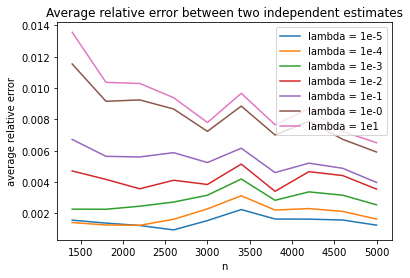

In [102]:
# Compute the average relative error for two independent runs

avg_errs = np.zeros((len(lambda_vals), len(n_vals)))
for i in range(1,len(lambda_vals)):
    if lambda_vals[i] == np.inf:
        currlabel = 'lambda = 0'
    elif lambda_vals[i] >= 0:
        currlabel ='lambda = 1e-' + str(lambda_vals[i])
    elif lambda_vals[i] < 0:
        currlabel ='lambda = 1e' + str(-lambda_vals[i])
    
    avg_err = np.zeros(len(n_vals))
    for ind_1 in range(len(model_names)):
        model_name1 = model_names[ind_1]
        for ind_2 in range(ind_1+1, len(model_names)):
            model_name2 = model_names[ind_2]
            
            v0 = curr_mat1 = d_mat[(model_name1, model_name2, 0)][i,:]
            v1 = curr_mat2 = d_mat[(model_name1, model_name2, 1)][i,:]

            rel_err = np.abs(v0 - v1) / (v0 + v1)
#             print(v0)
#             print(v1)
#             print('rel_err',rel_err)
#             print(i)
            assert(np.all(v0 > 0))
            assert(np.all(v1 > 0))
            avg_err += rel_err
    avg_errs[i,:] = avg_err / ((len(model_names) * (len(model_names) - 1) / 2))
    
    plt.plot(n_vals, avg_errs[i,:], label=currlabel)

plt.title('Average relative error between two independent estimates')
plt.xlabel('n')
plt.ylabel('average relative error')
plt.legend()
plt.show()
            
            
    
# plt.legend()
# plt.ylim((0.95, 1.05))
# plt.title('Ratio of distance estimates for ' + model_names[0] + ' and ' + model_names[1] + ' between two runs on independent samples')
# plt.show()
            
#             final_val = curr_mat[i,-1]
#             curr_l = curr_l + curr_mat[i,:] / final_val
#             curr_err = curr_err + np.abs((curr_mat[i,:] - final_val) / final_val)
#     avg_err = curr_err / (len(model_names) * (len(model_names) - 1) / 2)
#     avg_l = curr_l / (len(model_names) * (len(model_names) - 1) / 2)
# #     diff_l = avg_l[0:-2] - avg_l[1:-1]
# #     print(diff_l)
# #     plt.plot(n_vals, avg_l, label=currlabel)
#     plt.plot(n_vals, avg_err, label=currlabel)
# #     plt.ylim((0,2))
# #     plt.ylim((-0.2,0.2))
# plt.legend()
# plt.title('average relative error of $\hat{d}_{\lambda}^{(n)}$ with respect to $\hat{d}_{\lambda}^{(10000)}$')
# plt.xlabel('n')
# plt.ylabel('average relative error')
# plt.show()

# For MNIST

In [106]:
mnist_folder = '../mnist_experiments/'
train_dataset = torchvision.datasets.MNIST(root=mnist_folder + 'data/',
                                        train=True,
                                        transform=transforms.ToTensor())

# Generate matrix of all train data images
full_train_data = []
for i in range(len(train_dataset)):
    full_train_data.append(train_dataset[i][0].reshape(-1, 28*28))
full_train_data = torch.vstack(full_train_data)

In [107]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../mnist_experiments/data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [108]:
modeldir = mnist_folder + '/models/widthdepth/'

In [112]:
name1 = 'width1000_depth10_seed3'

In [114]:
rep1.shape

(1000, 60000)

In [313]:
model_names = []
widths = [800]
seeds = [1,2]
depths = [1]
for width in widths:
    for depth in depths:
        for seed in seeds:
            model_names.append(f'width{width}_depth{depth}_seed{seed}')

In [314]:
print(model_names)

['width800_depth1_seed1', 'width800_depth1_seed2']


In [325]:
model_names = ['width800_depth1_seed1', 'width800_depth10_seed2']

In [344]:
# Load MNIST representations
reps = {}
for model_name in model_names:
    print(model_name)
    model1_path = f'{modeldir}{model_name}.pth'
    model1_lastlayer = torch.load(model1_path)[0:-1]
    rep1 = model1_lastlayer(full_train_data).detach().numpy().T
    # center and normalize
    rep1 = rep1 - rep1.mean(axis=1, keepdims=True)
    num_data = rep1.shape[1]
    rep1 = math.sqrt(num_data) * rep1 / np.linalg.norm(rep1)
    reps[model_name] = rep1

width800_depth1_seed1
width800_depth10_seed2


In [345]:
print(reps['width800_depth1_seed1'])

[[-0.02473364  0.00985302 -0.02473364 ... -0.02473364 -0.02473364
   0.02984422]
 [-0.0275785  -0.0230787  -0.0198618  ... -0.0275785  -0.02659984
   0.01794538]
 [ 0.024202    0.01725131 -0.02875106 ...  0.00764309 -0.02875106
  -0.01134534]
 ...
 [-0.01708007  0.02698059 -0.04145558 ... -0.02275419 -0.00846665
  -0.01009434]
 [-0.04096873 -0.01477273 -0.01621888 ... -0.04096873 -0.03226613
  -0.04096873]
 [ 0.00986205 -0.0351388  -0.0351388  ... -0.0351388  -0.0351388
  -0.0351388 ]]


In [346]:
print(reps['width800_depth10_seed2'])

[[-8.5639412e-04 -8.5639412e-04 -8.5639412e-04 ... -8.5639412e-04
  -8.5639412e-04 -8.5639412e-04]
 [-1.7972937e-02 -1.7972937e-02  2.1251326e-02 ... -1.7972937e-02
   4.3328782e-03  1.2883648e-02]
 [ 1.5011717e-02 -2.9186659e-02  4.0717151e-02 ...  1.9128932e-02
  -2.9186659e-02 -2.9186659e-02]
 ...
 [-2.0248596e-08 -2.0248596e-08 -2.0248596e-08 ... -2.0248596e-08
  -2.0248596e-08 -2.0248596e-08]
 [-1.0608120e-02 -1.0608120e-02  3.3934183e-02 ... -1.0608120e-02
  -1.0608120e-02 -1.0608120e-02]
 [ 3.4095716e-02 -2.7722018e-03 -2.7722018e-03 ...  3.5000864e-02
  -2.7722018e-03 -2.7722018e-03]]


In [347]:
def predictor_dist_temp(A, B, evals_a=None, evecs_a=None, evals_b=None, evecs_b=None, cov_ab=None, lmbda=0):
    """
    Computes distance bewteen best linear predictors on representations A and B
    """
    k, n = A.shape
    l, _ = B.shape
    assert k <= n
    assert l <= n
    
    if evals_a is None or evecs_a is None:
        evals_a, evecs_a = np.linalg.eigh(A @ A.T)
    if evals_b is None or evecs_b is None:
        evals_b, evecs_b = np.linalg.eigh(B @ B.T)

    evals_a = (evals_a + np.abs(evals_a)) / (2 * n)
    evals_b = (evals_b + np.abs(evals_b)) / (2 * n)
    
    if lmbda > 0:
        inv_a_lmbda = np.array([1 / (x + lmbda) if x > 0 else 1 / lmbda for x in evals_a])
    else:
        inv_a_lmbda = np.array([1 / x if x > 0 else 0 for x in evals_a])

    if lmbda > 0:
        inv_b_lmbda = np.array([1 / (x + lmbda) if x > 0 else 1 / lmbda for x in evals_b])
    else:
        inv_b_lmbda = np.array([1 / x if x > 0 else 0 for x in evals_b])
    
    
# #     w = lmbda / evals_a
#     evals_a_times_inv = np.array([1 / (1 + lmbda / x) if x < 10**2 * lmbda else 1 - lmbda / x + ((lmbda / x)**2) - ((lmbda / x)**3) for x in evals_a])
#     T1 = np.sum(np.square(evals_a_times_inv))
    
# #     w2 = lmbda / evals_b
#     evals_b_times_inv = np.array([1 / (1 + lmbda / x) if x < 10**2 * lmbda else 1 - lmbda / x + ((lmbda / x)**2) - ((lmbda / x)**3) for x in evals_b])
#     T2 = np.sum(np.square(evals_b_times_inv))
    
    T1 = np.sum(np.square(evals_a * inv_a_lmbda))
    T2 = np.sum(np.square(evals_b * inv_b_lmbda))
    
    if cov_ab is None:
        cov_ab = A @ B.T / n
    
#     print(np.sum(cov_ab))
        
    T3 = np.trace(
        (np.diag(np.sqrt(inv_a_lmbda)) @ evecs_a.T)
        @ cov_ab
        @ (evecs_b @ np.diag(inv_b_lmbda) @ evecs_b.T)
        @ cov_ab.T
        @ (evecs_a @ np.diag(np.sqrt(inv_a_lmbda)))
    )
    
#     print('T3 old',T3)
    
#     T3 = 0
    
    return T1 + T2 - 2*T3

In [348]:
def predictor_dist_empirical_covs(A, B, lmbda=0):
    """
    Computes distance bewteen best linear predictors on representations A and B
    """
    k, n = A.shape
    l, _ = B.shape
    assert k <= n
    assert l <= n
    
    Sphi = A @ A.T / n
    Spsi = B @ B.T / n
    Sphipsi = A @ B.T / n 
    
    Sphiinv = np.linalg.inv(Sphi + lmbda * np.eye(k))
    Spsiinv = np.linalg.inv(Spsi + lmbda * np.eye(l))
    
    T1 = np.trace(Sphiinv @ Sphi @ Sphiinv @ Sphi)
    T2 = np.trace(Spsiinv @ Spsi @ Spsiinv @ Spsi)
    
    T3 = np.trace(Sphiinv @ Sphipsi @ Spsiinv @ Sphipsi.T)
#     print('T3 new',T3)
    
    return T1 + T2 - 2*T3

In [371]:
# Estimate eigenvalues
lambda_vals = [5, 2, 3, 1]
n_vals = np.arange(2000,62000,2000)
d_mat = {}
evals_evecs = {}
for model_name in model_names:
    print(model_name)
    for n_ind in range(len(n_vals)):
        n = n_vals[n_ind]
        A = reps[model_name][:,0:n]
        evals_a, evecs_a = np.linalg.eigh(A @ A.T)
        evals_evecs[(model_name, n)] = (evals_a, evecs_a)
        
for ind_1 in range(len(model_names)):
    print(ind_1,'/',len(model_names))
    model_name1 = model_names[ind_1]
    for ind_2 in range(ind_1+1,len(model_names)):
        model_name2 = model_names[ind_2]
        print(model_name1, model_name2)
        new_mat = np.zeros((len(lambda_vals),len(n_vals)))
        
        for n_ind in range(len(n_vals)):
            n = n_vals[n_ind]
            A = reps[model_name1][:,0:n]
            B = reps[model_name2][:,0:n]
            evals_a, evecs_a = evals_evecs[(model_name1, n)]
            evals_b, evecs_b = evals_evecs[(model_name2, n)]
#             plt.scatter(range(len(evals_a)), np.log10(evals_a))
#             plt.show()

            covAB = A @ B.T / n
#             print(n)
            for i in range(len(lambda_vals)):
#                 print('lambda',i)
#                 print(evals_a)
                if lambda_vals[i] == np.inf:
                    curr_dist = predictor_dist_temp(A, B, evals_a=evals_a, evecs_a = evecs_a, evals_b = evals_b, evecs_b = evecs_b, cov_ab = covAB, lmbda=0)

                    #                     print('0\t',curr_dist)
                    new_mat[i,n_ind] = curr_dist
                else:
#                     curr_dist_1 = predictor_dist_temp(A, B, lmbda=math.pow(10,-lambda_vals[i]))
                    curr_dist = predictor_dist_temp(A, B, evals_a=evals_a, evecs_a = evecs_a, evals_b = evals_b, evecs_b = evecs_b, cov_ab = covAB, lmbda=math.pow(10,-lambda_vals[i]))
#                     print(curr_dist_1,curr_dist) 
#                     curr_dist = predictor_dist_empirical_covs(A, B, lmbda=math.pow(10,-lambda_vals[i]))
#                     print('old',curr_dist_2 / math.pow(10,-2 * lambda_vals[i]))
#                     print('new',curr_dist * math.pow(100,-lambda_vals[i]))
#                     print('1e-' + str(lambda_vals[i]) + '\t',curr_dist)
                    new_mat[i,n_ind] = curr_dist
        
        d_mat[(model_name1, model_name2)] = new_mat
    

width800_depth1_seed1
width800_depth10_seed2
0 / 2
width800_depth1_seed1 width800_depth10_seed2
1 / 2


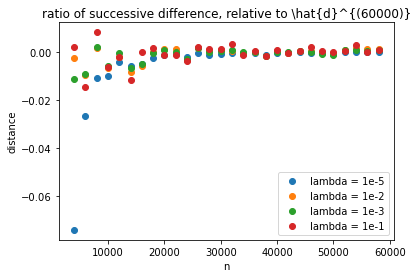

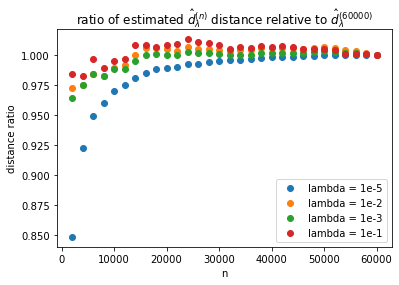

In [376]:
for i in range(len(lambda_vals)):
    if lambda_vals[i] == np.inf:
        currlabel = 'lambda = 0'
    elif lambda_vals[i] >= 0:
        currlabel ='lambda = 1e-' + str(lambda_vals[i])
    elif lambda_vals[i] < 0:
        currlabel ='lambda = 1e' + str(-lambda_vals[i])
    
    curr_l = np.zeros(len(n_vals))
    for ind_1 in range(len(model_names)):
        model_name1 = model_names[ind_1]
        for ind_2 in range(ind_1+1, len(model_names)):
            model_name2 = model_names[ind_2]
            
            curr_mat = d_mat[(model_name1, model_name2)]
            final_val = curr_mat[i,-1]
            curr_l = curr_l + curr_mat[i,:] / final_val
    avg_l = curr_l / (len(model_names) * (len(model_names) - 1) / 2)
    diff_l = avg_l[0:-2] - avg_l[1:-1]
#     print(diff_l)
    plt.scatter(n_vals[1:-1], diff_l, label=currlabel)
#     plt.ylim((0,2))
#     plt.ylim((-0.2,0.2))
plt.legend()
plt.title('ratio of successive difference, relative to \hat{d}^{(' + str(n_vals[-1]) + ')}')
plt.xlabel('n')
plt.ylabel('distance')
plt.show()

for i in range(len(lambda_vals)):
    if lambda_vals[i] == np.inf:
        currlabel = 'lambda = 0'
    elif lambda_vals[i] >= 0:
        currlabel ='lambda = 1e-' + str(lambda_vals[i])
    elif lambda_vals[i] < 0:
        currlabel ='lambda = 1e' + str(-lambda_vals[i])
    
    curr_l = np.zeros(len(n_vals))
    for ind_1 in range(len(model_names)):
        model_name1 = model_names[ind_1]
        for ind_2 in range(ind_1+1, len(model_names)):
            model_name2 = model_names[ind_2]
            
            curr_mat = d_mat[(model_name1, model_name2)]
            final_val = curr_mat[i,-1]
            curr_l = curr_l + curr_mat[i,:] / final_val
            
#             plt.title(currlabel)
#             plt.scatter(n_vals, curr_mat[i,:])
#             plt.show()
#             break
#         break
    avg_l = curr_l / (len(model_names) * (len(model_names) - 1) / 2)
#     diff_l = avg_l[0:-2] - avg_l[1:-1]
#     print(diff_l)
    plt.scatter(n_vals, avg_l, label=currlabel)
#     plt.ylim((0,2))
#     plt.ylim((-0.2,0.2))
plt.legend()
plt.title('ratio of estimated $\hat{d}_{\lambda}^{(n)}$ distance relative to $\hat{d}_{\lambda}^{(' + str(n_vals[-1]) + ')}$')
plt.xlabel('n')
plt.ylabel('distance ratio')
plt.show()

In [368]:
d_mat

{('width800_depth1_seed1',
  'width800_depth10_seed2'): array([[436.27670048, 458.29589187, 474.70876153, 485.73359307,
         495.90269484, 503.35007788, 509.95879087, 515.17068244,
         520.57759222, 525.01540205, 528.09990298, 530.57129988,
         533.47259477, 537.02137459, 539.1322941 , 540.99564351,
         542.88072361, 544.52764408, 547.03690168, 548.82824521,
         550.53715637, 551.74661531, 552.72533374, 553.95055888,
         554.77849448, 555.71675453, 556.48870053, 556.97144576,
         557.23579153, 558.2819898 , 558.71556255, 559.51969724,
         559.72042188, 560.30084858, 561.20942102, 561.73188326,
         562.20604433, 563.00089611, 564.11295345, 564.67701838,
         564.99352328, 565.49549732, 566.31089052, 566.84950881,
         566.97548261],
        [ 10.83268459,  11.15496962,  11.23921221,  11.13949073,
          11.16397313,  11.13348023,  11.13509547,  11.15283628,
          11.18685162,  11.18503987,  11.17621251,  11.15569964,
          1